I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insight on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install pyabsa --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

2024-07-02 03:27:38.256290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 03:27:38.256446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 03:27:38.433333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-02 03:27:57] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






In [3]:
!pip install praw duckdb jupysql bertopic groq pyabsa --quiet

/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [4]:
import os
from pprint import pprint

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 

## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

/opt/conda/lib/python3.10/site-packages/nltk/decorators.py:69: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(regargs, varargs, varkwargs, defaults,


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Deploy Panel apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


/opt/conda/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  d

# Get the data (YouTube and Reddit)
If there is not enough data, augment data with synonyms

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [5]:
user_secrets = UserSecretsClient()

In [6]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [7]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [8]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

,author,published_at,like_count,text,video_id
409,@juniorortiz7631,2024-06-15T07:31:37Z,0,"Wow, you can move your icons 🤯",qkYoBNdcXBU
1823,@BalramNair,2024-06-12T04:45:08Z,2,"I bet it was hard to hold back that laughter when you said ""you will finally be able to put icons wherever you want on the ios 18 homescreen"" 2:50",qkYoBNdcXBU
4725,@gogo22976,2024-06-11T14:43:52Z,0,"""Most of the stuff happens on the device"". That's a big one. Today, you cannot even set your egg timer with Siri without an Internet connection.",qkYoBNdcXBU
375,@roblax87,2024-06-15T15:49:36Z,0,Talk about burying the lead,qkYoBNdcXBU
78,@pm-dev,2024-06-11T05:03:23Z,0,I hope the ChatGPT integration along with the others will be optional / opt-in,p2dhZ3AoDDs


In [9]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [10]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

,author,published_at,like_count,text,youtube_channel,published_at_date,published_at_month
649,@jadencresser,2024-06-13 18:11:07,0,14:29 that a years old feature,MKBHD,2024-06-13,6
8314,@oleabetsoemokoena12,2024-06-11 08:34:34,0,1:00 John McAfee *The Apple Way*,MKBHD,2024-06-11,6
6540,@182gonza,2024-06-11 11:18:19,0,I thought that the biggest change on the vision OS was that now they support the magic mouse.,MKBHD,2024-06-11,6
6271,@basam17,2024-06-11 11:46:51,0,but why reading the points from a Samsung ..... MARQUES,MKBHD,2024-06-11,6
1946,@brandontea3815,2024-06-12 03:33:09,0,"I actually think Apple is the only big tech left that actually see ML as it is, Machine Learning. I believe this is big influence from Steve Wozniak. For focusing on privacy for so many years, I believe they do have the most experience in protecting data. Though, time will tell. I’m actually quite happy with what Apple did. Instead of just solely milking money.",MKBHD,2024-06-12,6


In [11]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9837
The Verge     483
Name: count, dtype: int64

In [12]:
df0['app'] = 'YouTube'

In [13]:
len(df0)

10320

In [14]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [15]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [16]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [17]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [18]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         813   
1                   6         528   
2                   6         879   
3                   6         133   
4                   6          92   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [19]:
len(reddit_df)

1343

In [20]:
reddit_df['app'] = 'Reddit'

In [21]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [22]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [23]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [24]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11663

In [25]:
df.head()

,author,published_at,like_count,text,published_at_date,published_at_month,app
0,@chrmakri,2024-07-02 02:59:48,0,How much money for simping for apple?,2024-07-02,7,YouTube
1,@KADILALALARGICHI,2024-07-01 04:03:39,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,7,YouTube
2,@Cromysome,2024-07-01 02:56:00,0,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,2024-07-01,7,YouTube
3,@lovepassionpurpose3369,2024-06-30 20:59:46,0,Hakka tan,2024-06-30,6,YouTube
4,@luqman_azeem,2024-06-30 17:27:19,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,6,YouTube


# With only 12,000 samples, augment data using synonyms?

# Perform Bertopic Modeling

In [26]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-02 03:30:55,638 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-07-02 03:32:49,160 - BERTopic - Embedding - Completed ✓
2024-07-02 03:32:49,161 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-02 03:33:31,960 - BERTopic - Dimensionality - Completed ✓
2024-07-02 03:33:31,962 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-02 03:33:43,832 - BERTopic - Cluster - Completed ✓
2024-07-02 03:33:43,843 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-02 03:34:03,663 - BERTopic - Representation - Completed ✓


Topic  Count                                                  Name  \
0       -1   2774                         -1_ai_features_android_google   
1        0    995                   0_calculator_ipad_handwriting_maths   
2        1    531                           1_apple_stock_products_shit   
3        2    455                  2_siri_accessibility_typing_settings   
4        3    381                            3_notes_mkbhd_galaxy_event   
..     ...    ...                                                   ...   
113    112     17                   112_universal_button_switcher_kinks   
114    113     16  113_updates_underwhelming_huuuuuuuuugggggeeee_lamest   
115    114     16                    114_boring_lame_tiresome_curiosity   
116    115     15             115_centre_swipe_anticompetitive_bullcrap   
117    116     15                         116_sleep_surgery_tonight_bud   

                                                                                                       Representation  \
0                                          [ai, features, android, google, video, really, screen, ios, apps, devices]   
1                               [calculator, ipad, handwriting, maths, note, thing, students, high, pencil, homework]   
2                                 [apple, stock, products, shit, features, ideas, tech, music, innovative, customers]   
3                           [siri, accessibility, typing, settings, voice, button, assistant, search, updated, older]   
4                                            [notes, mkbhd, galaxy, event, updates, reads, talking, review, lol, ios]   
..                                                                                                                ...   
113                              [universal, button, switcher, kinks, discord, apps, torch, gestures, invent, acting]   
114  [updates, underwhelming, huuuuuuuuugggggeeee, lamest, expectations, gimmicky, biggest, excited, imo, innovative]   
115                        [boring, lame, tiresome, curiosity, interesting, useless, button, basically, feel, things]   
116            [centre, swipe, anticompetitive, bullcrap, carousel, springboard, presets, miui, horizontal, disabled]   
117                                                  [sleep, surgery, tonight, bud, 4am, stayed, hell, care, im, lol]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [27]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-02 03:34:34,827 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-02 03:34:49,245 - BERTopic - Dimensionality - Completed ✓
2024-07-02 03:34:49,248 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-02 03:35:00,024 - BERTopic - Cluster - Completed ✓
2024-07-02 03:35:00,040 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-02 03:35:16,826 - BERTopic - Representation - Completed ✓


CPU times: user 1min 59s, sys: 23.7 s, total: 2min 23s
Wall time: 1min 12s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4458,-1_android_features_like_ai,"[android, features, like, ai, years, ios, don, users, app, video]","[Here's what I think about this update - \n1. If it runs most of the AI stuff on device and the personal cloud computing really does what Apple says, like not storing any data, being totally encrypted etc and IF WE CAN IMPROVE THE AI IN OUR PHONE using our own data without sending it back to any server then it's huge, like massive. \n\n2. The new icons especially the tinted one sucks, overall I feel the UI does give more freedom but it doesn't look that good, it comes nowhere near material design.\n\n3. This is probably the biggest iOS update in a long time if Apple can make Siri more powerful, or powerful enough that we don't need to do anything in chatGpt at all then I can really see a reason to go for pro models, ""As you can see, all the same iPhones running iOS 17 can be updated to iOS 18. However, there’s a catch. According to Apple, only the iPhone 15 Pro and iPhone 15 Pro Max are compatible with the new AI, or Apple Intelligence, features. This is because these features require the A17 Pro or M1 chip or later.""\n\n \nI have an 11 Pro Max. Does this mean Siri won't work?, I ditched iPhone a couple years ago to use Samsung because I use Windows PC's and don't like MacOS. But I still like to watch videos like these to keep up with what they're doing. Very cool what they are doing. I can't believe it took them until 2024 to allow people to customize icons on the home screen, though. Btw, I like how Marques reads his list off his Ultra phone. Samsung phones really are great. Can you multitask yet on an iPhone or is it still one app at a time kind of thing? Vision Pro looks really cool. I might be enticed to come back to Apple.]"
1,0,666,0_samsung_s24_ultra_notes,"[samsung, s24, ultra, notes, marques, mkbhd, updates, funny, ios, talking]","[You are reading iOS features from Samsung Ultra 😉, Reading from your Samsung, As Marques is reading his notes of a Samsung Ultra. 😂]"
2,1,552,1_siri_type_accessibility_voice,"[siri, type, accessibility, voice, settings, chatgpt, bixby, carplay, button, homepods]","[How to get the ai Siri 😭, Siri at last., What have they done to Siri...]"
3,2,493,2_intelligence_artificial_apple_genius,"[intelligence, artificial, apple, genius, sounds, naming, chatgpt, branding, openai, did]","[AI = Apple Intelligence 😂, AI = Apple Intelligence 🤡, AI = Apple Intelligence... ]"
4,3,364,3_icons_ugly_homescreen_apps,"[icons, ugly, homescreen, apps, dark, tint, widgets, customisation, packs, themes]","[Why not just have icon packs. People would go crazy if you could have iOS 6 icons on your homescreen., Man. I'm excited about AI baked into iOS for sure. I was hoping to see them talk about iOS keyboard improvements tho. Hopefully ChatGPT is used to make their swipe text prediction better, because it's absolutely horrible. Also..... how in 2024 do we not have a GD MF'N NUMBER ROW??? I'm over this shit. I have to use Swiftkey because it's that important of a keyboard feature for me. \n\nThe home screen customization is welcomed, but the icon hue slider is going to create some ugly home screens. All of this new customization they're giving us and they don't do anything with icon packs? That would have been great. One neat thing I noticed is the ability to remove icon app names, but they way it's implemented isn't very Apple Intelligent. The icons are expanded in size, removing the app names. It would have been much better to just give us a toggle. I don't want larger icons. I'm still going to stick with my custom icons that I don't give a name to., You couldn't move around the icons on the home screen on iPhone until 2024?]"
...,...,...,...,...,...
97,96,17,96_jobs_steve_grave_tornado,"[jobs, steve, grave, tornado, coal, ipon, customisability, yawn, colors, homescreen]","[Apple died with Steve Jobs., Steve Jobs is rolling in his grave on the colors, Steve J

In [28]:
topic_model.get_topic(0) # top topic

[('samsung', 0.09869116863621466),
 ('s24', 0.05404123006214058),
 ('ultra', 0.05158511948210545),
 ('notes', 0.03845938257188122),
 ('marques', 0.031572535091720456),
 ('mkbhd', 0.030159739048194672),
 ('updates', 0.020359632825180076),
 ('funny', 0.015308843649913044),
 ('ios', 0.013840721503651131),
 ('talking', 0.011969275107516011)]

These topics seem more interpretable due to better embeddings.

#### BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [29]:
topic_model.visualize_topics()

The biggest topic after the outlier topic (0) was topic 1 which was about Siri. I used the slider to highlight the bubble. When you hover over the bubble, you see the words associated with the topic.

In [30]:
topic_model.visualize_barchart(top_n_topics=8)

Looks like some other huge topics were criticism of Apple being behind in development including the AI frontier. Though a huge win was the showcasing of the interactive/predictive calculator.

In [31]:
topic_model.visualize_heatmap()

# Perform Sentiment and Emotion Classification

* Not sure what the benchmark is for good separation between topics. 
* Considering topics not along the diagonal and not associated with topic 0.  
* Most topics are 0.4 or below in similarity score. This means there are nice distinct topics discovered under better embeddings and BERTopic model.

In [32]:
# using Hugging Face sentiment classifier trained on pre-trained on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Will use an LLM to summarize down to the necessary amount of sentences. Will need to use a Tokenizer to determine max sentences for summary cut-off.

Using cased model so case-sentitive text used to train model. so for inference, no need for lowering text

In [33]:
# Need to make comments text as similar as it was for model training for sentiment inference: remove HTML tags
# Need to also get rid of weird tags since model was not trained on that for inference

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text
0,@chrmakri,2024-07-02 02:59:48,0,How much money for simping for apple?,2024-07-02,7,YouTube,"[0.019729141145944595, -0.05878586694598198, 0.05441534146666527, -0.015379936434328556, 0.039667852222919464, -0.04139961302280426, -0.0029291179962456226, -0.05119359865784645, -0.040580250322818756, -0.10712337493896484, -0.07132219523191452, 0.014407429844141006, -0.06653469800949097, -0.06596135348081589, -0.11431335657835007, 0.0379570871591568, 0.028373239561915398, -0.06786742061376572, 0.0549079105257988, -0.06412579864263535, -0.022943593561649323, -0.01949514076113701, -0.024542590603232384, -0.01418924331665039, -0.015275637619197369, 0.11248413473367691, 0.004027840215712786, -0.02686292491853237, -0.010725932195782661, 0.014775519259274006, -0.009772130288183689, 0.01071717869490385, -0.0025252916384488344, 0.020675089210271835, -0.04598378390073776, -0.006814762018620968, -0.03401179611682892, 0.007003767881542444, -0.0343584381043911, -0.040966250002384186, 0.08441152423620224, 0.017110491171479225, -0.023500243201851845, 0.03157548978924751, 0.01153349969536066, 0.025803396478295326, 0.024461321532726288, 0.017535779625177383, 0.0012610730482265353, -0.06927232444286346, -0.03149054944515228, 0.11040054261684418, -0.012122576124966145, -0.010098593309521675, -0.1058894619345665, -0.041054412722587585, -0.03892309218645096, 0.03829929977655411, -0.009176953695714474, 0.02784915827214718, 0.009576866403222084, -0.07027077674865723, 0.04147012531757355, -0.08467086404561996, -0.006310667842626572, -0.022646332159638405, -0.027753205969929695, -0.01048186793923378, -0.008323912508785725, 0.007239845581352711, -0.08710967749357224, 0.07998576760292053, -0.01788921095430851, -0.016687236726284027, 0.04901633784174919, -0.06954638659954071, -0.028633320704102516, 0.03606203943490982, 0.005708278622478247, 0.04932783171534538, 0.03882381319999695, 0.018440572544932365, -0.023697109892964363, -0.034501124173402786, -3.2706643651181366e-06, 0.046055592596530914, -0.02457617036998272, -0.060230597853660583, 0.056336913257837296, -0.026022927835583687, 0.03500256687402725, 0.0025565153919160366, 0.049954213201999664, 0.08322946727275848, 0.033752888441085815, -0.0436217226088047, 0.012439023703336716, 0.07393462210893631, -0.04151775687932968, -0.012992407195270061, ...]",How much money for simping for apple?
1,@KADILALALARGICHI,2024-07-01 04:03:39,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,7,YouTube,"[0.04311523213982582, -0.04549865052103996, -0.06084948778152466, -0.008767339400947094, -0.002074379473924637, -0.046884309500455856, -0.02635386399924755, -0.04559049755334854, -0.0473274290561676, 0.02103600464761257, 0.0500449500977993, 0.03655562177300453, 0.0036420319229364395, -0.06165294721722603, -0.0727270096540451, -0.032248929142951965, 0.057826656848192215, -0.0029281051829457283, 0.024642234668135643, -0.0654439851641655, -0.027068737894296646, 0.010844809003174305, -0.06436943262815475, 0.04813031107187271, 0.032326921820640564, 0.07254165410995483, 0.0612168088555336, 0.016277072951197624, -0.0019627688452601433, -0.041243776679039, -0.04685511440038681, 0.02542872354388237, -0.06930413097143173, -0.010952158831059933, 0.049101199954748154, -0.014233649708330631, -0.06261730194091797, 0.00020950705220457166, 0.05577321723103523, 0.033479444682598114, 0.055216822773218155, -0.04251083731651306, -0.024579456076025963, -0.05135362595319748, 0.06524527817964554, 0.02169010043144226, 0.024049758911132812, -0.022535642609000206, -0.021607521921396255, -0.05982566624879837, -0.05029882863163948, -0.03679678216576576, -0.014418878592550755, -0.004016074817627668, -0.07210424542427063, 0.0393318235874176, 0.06220274418592453, 0.005816936027258635, 0.03450177609920502, -0.07019925862550735, -0.05068998038768768, -0.050562407821416855, -0.008678498677909374, -0.005460104905068874, -0.0

In [34]:
# %%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. 
# Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 450 total words as max total words per comments since tokenizer can add suffixes as a token
#2. eliminate token lengths greater than max/SUMMARIZE comments using Grok since losing richness of dataset with eliminating comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens
0,@chrmakri,2024-07-02 02:59:48,0,How much money for simping for apple?,2024-07-02,7,YouTube,"[0.019729141145944595, -0.05878586694598198, 0.05441534146666527, -0.015379936434328556, 0.039667852222919464, -0.04139961302280426, -0.0029291179962456226, -0.05119359865784645, -0.040580250322818756, -0.10712337493896484, -0.07132219523191452, 0.014407429844141006, -0.06653469800949097, -0.06596135348081589, -0.11431335657835007, 0.0379570871591568, 0.028373239561915398, -0.06786742061376572, 0.0549079105257988, -0.06412579864263535, -0.022943593561649323, -0.01949514076113701, -0.024542590603232384, -0.01418924331665039, -0.015275637619197369, 0.11248413473367691, 0.004027840215712786, -0.02686292491853237, -0.010725932195782661, 0.014775519259274006, -0.009772130288183689, 0.01071717869490385, -0.0025252916384488344, 0.020675089210271835, -0.04598378390073776, -0.006814762018620968, -0.03401179611682892, 0.007003767881542444, -0.0343584381043911, -0.040966250002384186, 0.08441152423620224, 0.017110491171479225, -0.023500243201851845, 0.03157548978924751, 0.01153349969536066, 0.025803396478295326, 0.024461321532726288, 0.017535779625177383, 0.0012610730482265353, -0.06927232444286346, -0.03149054944515228, 0.11040054261684418, -0.012122576124966145, -0.010098593309521675, -0.1058894619345665, -0.041054412722587585, -0.03892309218645096, 0.03829929977655411, -0.009176953695714474, 0.02784915827214718, 0.009576866403222084, -0.07027077674865723, 0.04147012531757355, -0.08467086404561996, -0.006310667842626572, -0.022646332159638405, -0.027753205969929695, -0.01048186793923378, -0.008323912508785725, 0.007239845581352711, -0.08710967749357224, 0.07998576760292053, -0.01788921095430851, -0.016687236726284027, 0.04901633784174919, -0.06954638659954071, -0.028633320704102516, 0.03606203943490982, 0.005708278622478247, 0.04932783171534538, 0.03882381319999695, 0.018440572544932365, -0.023697109892964363, -0.034501124173402786, -3.2706643651181366e-06, 0.046055592596530914, -0.02457617036998272, -0.060230597853660583, 0.056336913257837296, -0.026022927835583687, 0.03500256687402725, 0.0025565153919160366, 0.049954213201999664, 0.08322946727275848, 0.033752888441085815, -0.0436217226088047, 0.012439023703336716, 0.07393462210893631, -0.04151775687932968, -0.012992407195270061, ...]",How much money for simping for apple?,9
1,@KADILALALARGICHI,2024-07-01 04:03:39,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,7,YouTube,"[0.04311523213982582, -0.04549865052103996, -0.06084948778152466, -0.008767339400947094, -0.002074379473924637, -0.046884309500455856, -0.02635386399924755, -0.04559049755334854, -0.0473274290561676, 0.02103600464761257, 0.0500449500977993, 0.03655562177300453, 0.0036420319229364395, -0.06165294721722603, -0.0727270096540451, -0.032248929142951965, 0.057826656848192215, -0.0029281051829457283, 0.024642234668135643, -0.0654439851641655, -0.027068737894296646, 0.010844809003174305, -0.06436943262815475, 0.04813031107187271, 0.032326921820640564, 0.07254165410995483, 0.0612168088555336, 0.016277072951197624, -0.0019627688452601433, -0.041243776679039, -0.04685511440038681, 0.02542872354388237, -0.06930413097143173, -0.010952158831059933, 0.049101199954748154, -0.014233649708330631, -0.06261730194091797, 0.00020950705220457166, 0.05577321723103523, 0.033479444682598114, 0.055216822773218155, -0.04251083731651306, -0.024579456076025963, -0.05135362595319748, 0.06524527817964554, 0.02169010043144226, 0.024049758911132812, -0.022535642609000206, -0.021607521921396255, -0.05982566624879837, -0.05029882863163948, -0.03679678216576576, -0.014418878592550755, -0.004016074817627668, -0.07210424542427063, 0.0393318235874176, 0.06220274418592453, 0.005816936027258635, 0.03450177609920502, -0.07019925862550735, -0.05068998038768768, -0.050562407821416855, -0.008678498677909374, -0.00546010490

In [35]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [36]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [37]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Try to use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [38]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here is a condensed version of the original comment in 15 sentences or less:\n\nI want to thank you for creating well-researched and informative videos. You're different from others who focus on being humorous, as you provide genuine tech news like a tech expert. As a software engineer, I have a suggestion to take your content to the next level. I believe Apple has used some of my ideas, and I'd be happy to share them. I think you should create a real tech news channel, similar to a 24/7 news outlet like CNN. This could put other tech influencers out of business. The idea is simple: join forces with other reputable tech journalists, like Brian Tong and those from Engadget, to create a channel that focuses on tech news, not politics. Our goal would be to hold tech companies accountable, just like traditional news outlets. The channel could include in-depth interviews with tech CEOs and anchors providing daily updates on the latest advancements in tech. This idea has the potential to be

In [39]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[1]

"I want to thank you for creating well-researched and informative videos. You're different from others who focus on being humorous, as you provide genuine tech news like a tech expert. As a software engineer, I have a suggestion to take your content to the next level. I believe Apple has used some of my ideas, and I'd be happy to share them. I think you should create a real tech news channel, similar to a 24/7 news outlet like CNN. This could put other tech influencers out of business. The idea is simple: join forces with other reputable tech journalists, like Brian Tong and those from Engadget, to create a channel that focuses on tech news, not politics. Our goal would be to hold tech companies accountable, just like traditional news outlets. The channel could include in-depth interviews with tech CEOs and anchors providing daily updates on the latest advancements in tech. This idea has the potential to be a multi-billion dollar concept."

In [40]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[1]))

201

* [x] Now write up a function in order to loop through Pandas text column that has >450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has 500 or less tokens
* After verification, perform sentiment and emotion analysis possibly using HF and Groq

In [41]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [42]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [43]:
condensed[1]

'The WWDC\'s iPad calculator app is just a gimmick, not worth the hype. MKBHD called it the only "incredible feature" from WWDC, but it\'s hardly used in real-world scenarios. The app can give answers as you write down a math question, adjust variables, and add graphs. However, these features are useless beyond 4th grade, as more complex math requires mental arithmetic and showing working out.\n\nA physical calculator is better for exams, as it\'s faster, easier, and representative of actual exam conditions. The iPad calculator app is inferior and can be replaced by a $200 physical calculator like the TI-Nspire. The app\'s features are impressive, but they\'re not practical or useful beyond primary school.\n\nFree software like Geogebra and Desmos offer more features and are just as good, if not better, than the iPad calculator. The physical calculator is just as good, if not better, for math work, and the iPad app is a complete gimmick. We need to stop blindly following hype and refle

In [44]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of >500 token comment. Now let us combine the two lists into two Pandas columns. And then join this to the original df on the non-condensed. And finally, create a new column that has >=500 tokens non-condensed and condensed text.

In [45]:
summarize_df['condensed_text'] = condensed

In [46]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [47]:
df.tail(1)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens,sent_count
314,Outlulz,2024-06-12 17:56:48,1,"And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",2024-06-12,6,Reddit,"[0.03637425974011421, 0.0018887761980295181, 0.013794836588203907, -0.024645013734698296, 0.07509669661521912, 0.029787365347146988, -0.01466673705726862, 0.02737506851553917, -0.08639978617429733, -0.021323829889297485, -0.02128777652978897, 0.026287969201803207, 0.01025031041353941, 0.0193417277187109, -0.08800722658634186, 0.08082183450460434, 0.056345097720623016, 0.07507497817277908, -0.007823891006410122, -0.019303735345602036, 0.000409406959079206, -0.01521315984427929, -0.036233916878700256, -0.05661900341510773, 0.02512439340353012, 0.08912590146064758, -0.05415946990251541, -0.045390866696834564, -0.03022334724664688, -0.007936893962323666, -0.06654815375804901, 0.03164668381214142, -0.012801420874893665, 0.0017923107370734215, -0.017152199521660805, -0.030316205695271492, 0.020496021956205368, -0.010173254646360874, -0.009121441282331944, -0.0070608993992209435, 0.08494159579277039, 0.06523647159337997, 0.0520232655107975, 0.0027275464963167906, 0.07034623622894287, 0.05289117991924286, 0.02846478298306465, -0.0030938787385821342, 0.021142514422535896, -0.022366231307387352, -0.05657031387090683, -0.021899281069636345, 0.014888428151607513, 0.01524202711880207, -0.08869250863790512, 0.04491351172327995, -0.032583288848400116, 0.01595481112599373, -0.013498134911060333, 0.0032672842498868704, -0.007392037194222212, 0.0112912030890584, 0.06271560490131378, -0.05778924748301506, -0.032137613743543625, 0.04428230598568916, 0.0006875982508063316, -0.021303579211235046, -0.051589880138635635, -0.05974290519952774, -0.087488554418087, 0.04596845060586929, 0.04342393949627876, 0.07218178361654282, 0.04401965066790581, 0.037772756069898605, 0.043139006942510605, -0.060950543731451035, 0.04557738080620766, 0.07643826305866241, 0.013018442317843437, 0.012988454662263393, -0.039187606424093246, 0.008744420483708382, 0.025889093056321144, -0.029244285076856613, 0.038473453372716904, -0.018668880686163902, 0.0728556290268898, 0.046057675033807755, -0.01409315038472414, 0.06307815760374069, -0.0037456313148140907, -0.04806210845708847, 0.015930339694023132, -0.018451916053891182, 0.028014715760946274, 0.0839536041021347, -0.03659583255648613, -0.06460489332675934, ...]","And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",28,1


In [48]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, use4, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?,None
1,@KADILALALARGICHI,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,YouTube,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",None
2,@Cromysome,0,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,2024-07-01,YouTube,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,None
3,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan,None
4,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",None


In [49]:
len(summarized_df)

11663

In [50]:
summarized_df.head(1)

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?,None


In [51]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1)
inf_df.head(5)

,author,like_count,original_text,published_at_date,app,final_text
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?
1,@KADILALALARGICHI,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,YouTube,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀"
2,@Cromysome,0,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,2024-07-01,YouTube,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind
3,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan
4,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?"


In [52]:
inf_df.isnull().sum()

author               41
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [53]:
len(summarize_df)

10

In [54]:
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger          99   
2     hammerheadtiger          10   
3     hammerheadtiger           4   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         879   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Great. /n is removed from text grabbed via API. Now let us re-tokenize the text to make sure we don't hit an error. 

In [55]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [56]:
query = """
select max(num_tokens)
from inf_df
"""
duckdb.query(query).df()

,max(num_tokens)
0,446


In [57]:
# The sentiment classifier still had some comments that exceeded 512 tokens. So need to eliminate more comments...
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [58]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

,author,like_count,original_text,published_at_date,app,final_text
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?


Great! Let us now get sentiment and emotion classifications.

In [59]:
len(inf_df)-len(inf_df2) # difference is small. so proceed.

0

## Sentiment Classification

In [60]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 20min 28s, sys: 3.21 s, total: 20min 31s
Wall time: 10min 16s


,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?,9,"[{'label': 'negative', 'score': 0.4305112361907959}]",negative,0.430511
1,@KADILALALARGICHI,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,YouTube,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",13,"[{'label': 'positive', 'score': 0.48311272263526917}]",positive,0.483113
2,@Cromysome,0,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,2024-07-01,YouTube,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,22,"[{'label': 'negative', 'score': 0.6047895550727844}]",negative,0.604790
3,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan,3,"[{'label': 'positive', 'score': 0.49844303727149963}]",positive,0.498443
4,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",44,"[{'label': 'positive', 'score': 0.7958763241767883}]",positive,0.795876


In [61]:
inf_df2.tail(2)

,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
11661,KLM_SpitFire,2,"**Lots** of great updates. There's so much to process. There are a handful of things that I didn't really like at first glance:\n\n1. All of the generative features. I didn't like how Microsoft started baking them into their software, and I don't really like them here. Can't place my finger on *why.* I feel like the Siri features are more essential for me. I'm **really** excited to play around with an enhanced Siri.\n2. The color-tinted icons. The effect reminds me of those cheap icon packs that circulated on the Play Store years ago. A developer would take official icons, add a tint, then dump them on the store en masse. I feel as though Apple heard the folks that have been wanting custom icon support, and this is some kind of stopgap.\n3. The Passwords app. I get this is going to be useful for many, many users that don't have good password management and hygiene. That said, I use Bitwarden. I really hope Apple doesn't begin to shove their Password solution down my throat.\n4. How blatantly ChatGPT branding is baked into the user-experience. Like, *whaaaat*? It feels very un-Apple to me. I love how native search engine support with auto-suggestions isn't supported on iOS — if you've ever tried to Google something from Spotlight, you probably know my pain — but I **can** have an OS-level supported ChatGPT conversation with ChatGPT branding? Wild. \n5. (Honestly, I'm glad they brought window snapping to Mac OS. That feature has been missing for so, so long. Stage Manager is not for me and never will be. That said, the 'old man' in me has really grown accustomed to my Swish + Alt-Tab setup. Hopefully I don't have to fight with these new OS features to continue using those tools.)\n6. (I find it ironic that the Settings app has become so complicated to navigate that a major sales pitch from today’s presentation was using the raw power of Apple’s flagship LLM to… navigate through settings. Not a complaint about the AI feature. Seems good. I’ll use it. I just feel that the Settings app has some other problems that seeing this feature triggered in my mind.)\n\nI get that there will be people that will use or benefit from these features, but as both a Software Engineer and consumer, feature bloat always makes me a little uncomfortable. That said, I’m very interested to get my hands on this release.",2024-06-10,Reddit,"I'm excited about the latest updates, but there are a few things that didn't quite sit well with me at first glance. The generative features feel like they're overkill, and I prefer Apple's Siri over Microsoft's. The color-tinted icons remind me of cheap icon packs from years ago, and I'm not a fan of Apple's password solution. I use Bitwarden, so I hope they don't push their solution on me. I'm surprised by the blatant ChatGPT branding in the user experience, as it feels un-Apple like. On the other hand, I'm glad they brought window snapping to Mac OS, and I appreciate the improved search functionality. However, I'm not a fan of Stage Manager, and I hope I can continue to use my preferred shortcuts. I also think it's ironic that the Settings app is complicated enough that Apple is using AI to navigate through it. As a Software Engineer and consumer, I'm always uncomfortable with feature bloat. Despite this, I'm looking forward to getting my hands on this release and exploring the new features.",241,"[{'label': 'negative', 'score': 0.5583739280700684}]",negative,0.558374
11662,kasakka1,0,"My takeaway was that across MacOS, iOS and iPadOS I found very few things that I could tell I would include in my daily use.\n\nI already use 1Password so Apple Passwords is not useful for me. I can already do corner splits with BetterTouchTool's snap functions. \n\nI could have used something like improvements to MacOS virtual desktop handling instead, e.g naming desktops, arranging them in some other manner than a 

<Axes: >

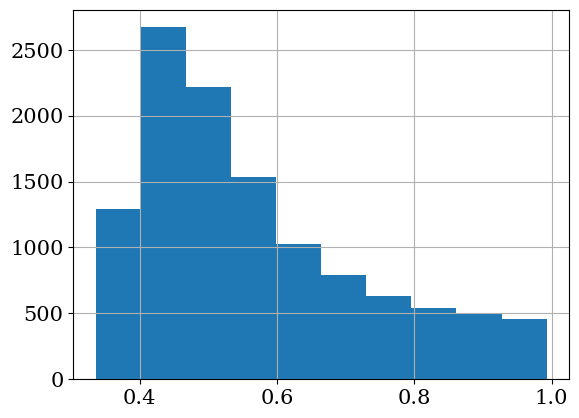

In [62]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. Let us try to see grok's sentiment accuracy.

In [63]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [64]:
inf_df2.head(1)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,How much money for simping for apple?,negative,0.430511


__________
# Attempt to use Groq as sentiment classifier starts here.

In [65]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

In [66]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentument: negative, neutral or positive as well as output the confidence score as a percentage. Output only the sentiment and score as a python dictionary inside a list in consistent format. For example only return: [{'sentiment': sentiment prediction, 'score': score percentage}].
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content
#     spl_word = '\n\n' #Trying to sanitize groq model re before adding to df
#     res = chat_completion.choices[0].message.content.split(spl_word, 1)
#     clean_res = re.findall(r'"([^"]*)"', res)

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 1.15 s, sys: 63.7 ms, total: 1.21 s
Wall time: 2min 38s


In [67]:
groq_sentiment[:10]

["Here is the sentiment classification result:\n\n [{'sentiment': 'negative', 'score': 93.4}]",
 "Here's the sentiment analysis result:\n```\n[\n    {'sentiment': 'negative', 'score': 82.0}\n]\n```\nIn this analysis, the sentiment of the comment is classified as negative with a confidence score of 82%. This score indicates that the model is 82% certain that the sentiment of the comment is negative.",
 "Here is the sentiment prediction and score for the given comment:\n```\n[{'sentiment': 'negative', 'score': 95.0}]\n```\nNote: The confidence score is an estimate and may vary depending on the specific model and training data used. In this case, I used a pre-trained sentiment analysis model from the Natural Language Processing (NLP) library TextBlob, which estimates the sentiment score as 95%.",
 "Here is the classification result:\n\n[{'sentiment': 'neutral', 'score': 55.0}]",
 "Here is the sentiment prediction:\n```\n[{'sentiment': 'positive', 'score': 72}]\n```\nNote that the confiden

In [68]:
list_df[0]['final_text'][:10]

0                                                                                                                                                             How much money for simping for apple?
1                                                                                                                        Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀
2                                                                                               Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind
3                                                                                                                                                                                         Hakka tan
4    It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?
5              I rea

In [69]:
# fxn framework

# def groq_pred (df):
#     groq_sentiment = []
#     for text in df['final_text']:
#         something
#     return final

In [70]:
# %%time

# Trying to add function to proven for loop through df['final_text']
# all_pred = []

# for sub_df in list_df[0]:
#     all_pred.append(groq_pred(sub_df))

In [71]:
# Make all predictions from chunks into one big list to add to original inf_df2

# flattened_list = list(itertools.chain(*all_pred))
# flattened_list[:2].head(5)

________

## Emotion Classification

In [72]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [73]:
%%time
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 20min 18s, sys: 4.23 s, total: 20min 22s
Wall time: 10min 14s


,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,how much money for simping for apple?,negative,0.430511,anger
1,@KADILALALARGICHI,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,YouTube,"apple intelligence, artificial intelligence, now a andriod intelligence 😂💀",positive,0.483113,joy
2,@Cromysome,0,Sick of apple to make ai for 15 pro. Leaving costumers that paid 1000 dollars for the 14 pro behind,2024-07-01,YouTube,sick of apple to make ai for 15 pro. leaving costumers that paid 1000 dollars for the 14 pro behind,negative,0.604790,anger
3,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,hakka tan,positive,0.498443,anger
4,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"it's great that apple will ask for permission everytime it wants to use chatgpt. the big question is: when it uses cloud compute, does it process the data to upgrade its own llm accordingly?",positive,0.795876,joy


## Sentiment and Emotion over Time

In [74]:
inf_df2.head(2)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion
0,@chrmakri,0,How much money for simping for apple?,2024-07-02,YouTube,how much money for simping for apple?,negative,0.430511,anger
1,@KADILALALARGICHI,1,"Apple intelligence, artificial intelligence, now a Andriod intelligence 😂💀",2024-07-01,YouTube,"apple intelligence, artificial intelligence, now a andriod intelligence 😂💀",positive,0.483113,joy


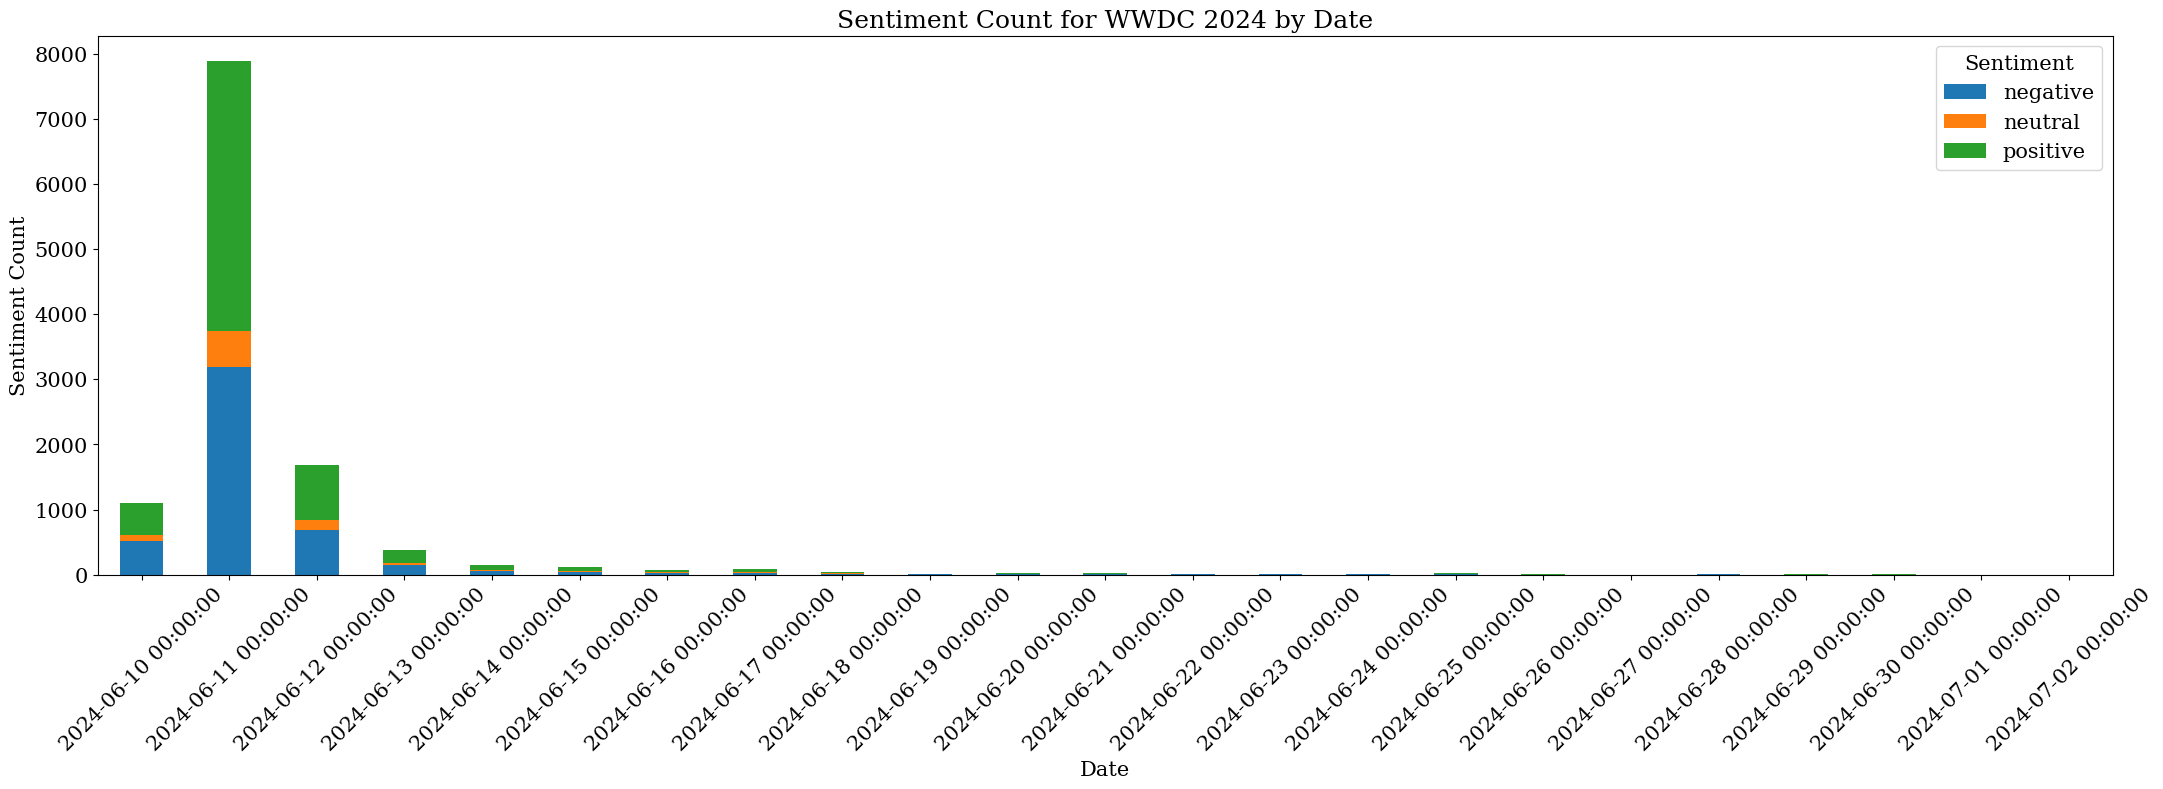

In [75]:
# For YouTube and Reddit users

# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

Most comments made on 6.11.24 and there is almost a split in sentiment between positive and negative. Let's take a look at the emotion breakdown. Mostly positive across days.

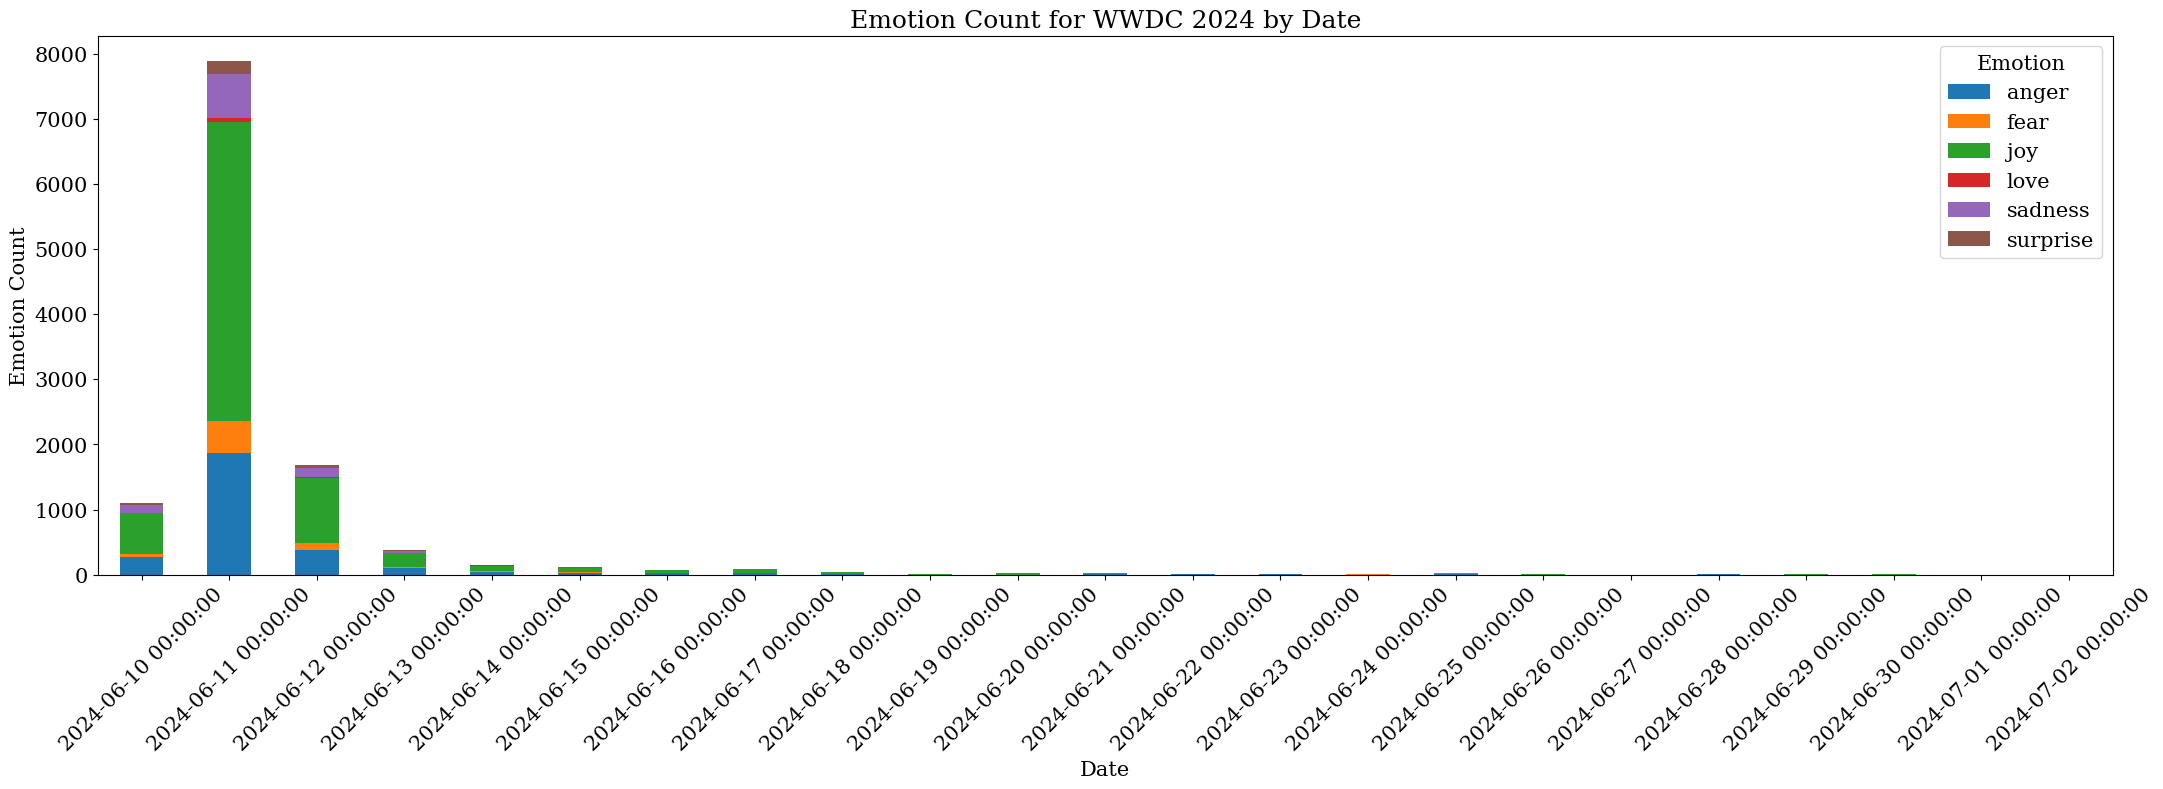

In [76]:
# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.show()

With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA) Using PyABSA

In [77]:
# Trying to get more granular with sentiment analysis. E.g. What particular features lead to joy/anger?

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-02 03:59:11] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-02 03:59:11] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-02 03:59:11] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-02 03:59:11] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-02 03:59:20] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-02 03:59:20] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-02 03:59:20] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-02 03:59:20] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-02 03:59:20] (2.4.1.post1) model: None
[2024-07-02 03:59:20] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-02 0

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [78]:
# Can pre-define aspects and see what the sentiment in text was. E.g.

# aspects = ["food", "service", "ambience"]

# text = """
# the service was absolutely horrible. 
# the restaurant was not very busy, and yet we waited over 1 hour for our food. 
# would not recommend if you are expecting good service. 
# additionally, the food was very sub par. the draft beer was flat, 
# and the other drinks were nothing special. 
# would advise elsewhere for mexican food.
# """
# d = {}
# for aspect in aspects:
#     d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
# d

In [79]:
# aspects = ["food", "service", "ambience"]

# def absa_general(text):

#     d = {}
#     for aspect in aspects:
#         d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
#     return d

# sample2['absa_gen'] = sample2.apply(lambda row: absa_general(row['clean_text']), axis=1)

In [80]:
# # Extract keys and create new columns
# for key in sample2['absa_gen'][0].keys():
#     sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# # Display the updated DataFrame
# sample2

In [81]:
# # Extract keys and create new columns
# for key in sample2['absa_gen'][0].keys():
#     sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# # Count occurrences of each sentiment for food, service, and ambience
# sentiments = ['Positive', 'Neutral', 'Negative']
# aspects = ['food', 'service', 'ambience']

# # Initialize an empty dictionary to hold the sentiment counts
# sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# # Populate the sentiment counts
# for aspect in aspects:
#     counts = sample2[aspect].value_counts()
#     for sentiment in sentiments:
#         if sentiment in counts:
#             sentiment_counts[aspect][sentiment] = counts[sentiment]

# # Create a DataFrame from sentiment counts
# sentiment_df = pd.DataFrame(sentiment_counts)

# # Plot the stacked bar chart
# sentiment_df.T.plot(kind='bar', stacked=True)

# # Customize the chart
# plt.title('Mexican Restaurants Sentiment Breakdown for Food, Service, and Ambience')
# plt.xlabel('Aspect')
# plt.ylabel('Count of Sentiments')
# plt.xticks(rotation=45)

# # Place the legend outside the plot
# plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust the layout to make room for the legend
# plt.tight_layout()

# # Show the plot
# plt.show()

In [82]:
# %%time

# # Make sure new dict created with aspects and sentiments
# def absa_sp(text):

#     atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
#                           pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
#                           )
#     aspect = atepc_result[0].get('aspect')
#     sentiment = atepc_result[0].get('sentiment')
#     new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
#     grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

#     for key, value in new_dict.items():
#         if value not in grouped_dict:
#             grouped_dict[value] = [key]
#         else:
#             grouped_dict[value].append(key)

#     # Convert keys into combined strings
#     grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
#     return grouped_dict


# inf_df2['absa_sp'] = inf_df2['final_text'].apply(lambda x: absa_sp([x]))

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

In [83]:
# entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
# ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
# ner_df

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: sentiment/emotion, number of topics, features mentioned

In [84]:
# # Each attribute we'll plot in the radar chart.
# labels = ['Acceleration', 'Displacement', 'Horsepower', 'MPG', 'Weight']

# # Let's look at the 1970 Chevy Impala and plot it.
# values = dft.loc['chevrolet impala 1970'].tolist()

# # Number of variables we're plotting.
# num_vars = len(labels)

# # Split the circle into even parts and save the angles
# # so we know where to put each axis.
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# # The plot is a circle, so we need to "complete the loop"
# # and append the start value to the end.
# values += values[:1]
# angles += angles[:1]

# # ax = plt.subplot(polar=True)
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # Draw the outline of our data.
# ax.plot(angles, values, color='red', linewidth=1)
# # Fill it in.
# ax.fill(angles, values, color='red', alpha=0.25)